In [33]:
from pprint import pp, pprint
from datetime import date

from prettytable import PrettyTable
import numpy as np 
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from run_regression import *


## Prepare the Dataset

In [34]:
# Load data from the CSV file
pumpkins = pl.read_csv("../data/US-pumpkins.csv", infer_schema_length=2000)
# Filter only the packages by bushel
pumpkins = pumpkins.filter(
  pl.col("Package").str.contains("bushel", literal=True))
# Select the desired attributes
pumpkins = pumpkins.select(
  ["Package", "Variety", "City Name", "Low Price", "High Price", "Date"])
# Transform into proper date datatype.
pumpkins = pumpkins.with_columns(
  [pl.col("Date").str.strptime(pl.Date, format="%m/%d/%y", strict=True)])
# Show a sample of the data
pumpkins.sample(n=10)

Package,Variety,City Name,Low Price,High Price,Date
str,str,str,f64,f64,date
"""1/2 bushel car…","""MINIATURE""","""NEW YORK""",16.0,18.0,2017-09-23
"""bushel cartons…","""PIE TYPE""","""SAN FRANCISCO""",16.0,18.0,2016-10-22
"""1/2 bushel car…","""MINIATURE""","""BALTIMORE""",15.0,15.0,2016-10-01
"""1/2 bushel car…","""MINIATURE""","""NEW YORK""",20.0,20.0,2016-09-24
"""1/2 bushel car…","""MINIATURE""","""CHICAGO""",17.0,18.0,2016-09-24
"""1/2 bushel car…","""MINIATURE""","""ST. LOUIS""",12.0,12.0,2016-09-30
"""1/2 bushel car…","""MINIATURE""","""COLUMBIA""",15.0,15.0,2017-09-30
"""1/2 bushel car…","""MINIATURE""","""SAN FRANCISCO""",20.0,20.0,2016-11-05
"""1/2 bushel car…","""MINIATURE""","""PHILADELPHIA""",16.0,18.0,2016-10-29


In [35]:
# Calculate average price
pumpkins = pumpkins.with_columns(
  [((pl.col("Low Price") + pl.col("High Price")) / 2.0).alias("Price")])
# Extract the month
months = pumpkins["Date"].dt.month().alias("Month")

In [36]:
# Get the day of the year
day_of_year = pumpkins.select(
  [
  pl.col("Date").apply(lambda dt: (dt - date(dt.year, 1, 1)).days).alias(
  "DayOfYear")
  ])


In [37]:
# Build a new dataframe for the dataset
pumpkins = pumpkins.with_columns(months)
pumpkins = pumpkins.with_columns(day_of_year)
pumpkins.sample(n=10)

Package,Variety,City Name,Low Price,High Price,Date,Price,Month,DayOfYear
str,str,str,f64,f64,date,f64,u32,i64
"""1/2 bushel car…","""MINIATURE""","""CHICAGO""",17.0,17.0,2016-11-05,17.0,11,309
"""1/2 bushel car…","""MINIATURE""","""CHICAGO""",17.0,17.0,2016-10-22,17.0,10,295
"""1 1/9 bushel c…","""MIXED HEIRLOOM…","""DETROIT""",20.0,20.0,2017-09-23,20.0,9,265
"""1 1/9 bushel c…","""PIE TYPE""","""CHICAGO""",17.0,19.0,2017-09-23,18.0,9,265
"""1/2 bushel car…","""MINIATURE""","""SAN FRANCISCO""",20.0,22.0,2016-10-22,21.0,10,295
"""bushel cartons…","""MINIATURE""","""COLUMBIA""",28.0,28.0,2016-10-22,28.0,10,295
"""1 1/9 bushel c…","""PIE TYPE""","""NEW YORK""",16.0,18.0,2016-10-15,17.0,10,288
"""1 1/9 bushel c…","""PIE TYPE""","""CHICAGO""",17.0,17.0,2016-10-29,17.0,10,302
"""bushel cartons…","""MINIATURE""","""COLUMBIA""",30.0,30.0,2016-10-01,30.0,10,274


In [38]:
# Adjust the price based on bushel size
pumpkins = pumpkins.with_columns(
  [
  pl.when(pl.col("Package").str.contains("1 1/9",
  strict=True)).then(pl.col("Price") / (1 + 1 / 9)).when(
  pl.col("Package").str.contains("1/2", strict=True)).then(
  pl.col("Price") / (1 / 2)).otherwise(pl.col("Price").alias("b"))
  ])

pumpkins.sample(n=10)

Package,Variety,City Name,Low Price,High Price,Date,Price,Month,DayOfYear
str,str,str,f64,f64,date,f64,u32,i64
"""1 1/9 bushel c…","""PIE TYPE""","""BOSTON""",15.0,16.0,2016-11-26,13.95,11,330
"""1/2 bushel car…","""MINIATURE""","""SAN FRANCISCO""",20.0,22.0,2016-10-08,42.0,10,281
"""1 1/9 bushel c…","""PIE TYPE""","""BOSTON""",15.0,16.0,2016-12-10,13.95,12,344
"""1/2 bushel car…","""MINIATURE""","""CHICAGO""",17.0,18.0,2016-10-15,35.0,10,288
"""1/2 bushel car…","""MINIATURE""","""ST. LOUIS""",15.0,15.0,2016-09-28,30.0,9,271
"""bushel cartons…","""PIE TYPE""","""SAN FRANCISCO""",16.0,18.0,2016-11-05,17.0,11,309
"""1/2 bushel car…","""MINIATURE""","""COLUMBIA""",18.0,18.0,2016-10-08,36.0,10,281
"""1 1/9 bushel c…","""PIE TYPE""","""BOSTON""",15.0,16.0,2016-10-29,13.95,10,302
"""1/2 bushel car…","""MINIATURE""","""COLUMBIA""",18.0,18.0,2016-10-01,36.0,10,274


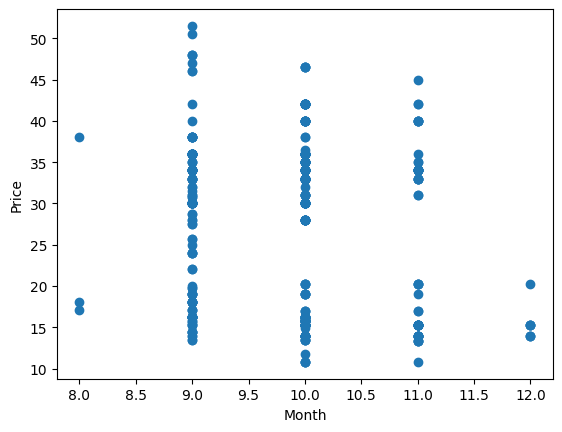

In [39]:
# Plot price and month (available data is from August through Decemeber)
plt.scatter("Month", "Price", data=pumpkins)
plt.xlabel("Month")
plt.ylabel("Price")
plt.show()

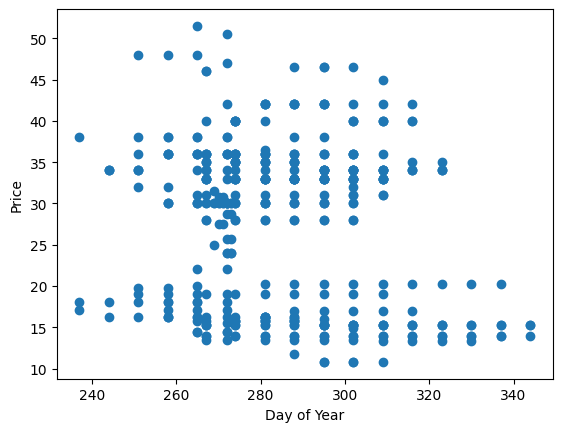

In [40]:
# Plot price and day of the year

plt.scatter("DayOfYear", "Price", data=pumpkins)
plt.xlabel("Day of Year")
plt.ylabel("Price")
plt.show()

In [41]:
# Correlation using the corr function

#np.corrcoef(pumpkins.select(["Month", "Price"]))
#c = pumpkins.select([pl.corr("Month", "Price")])

#pp(c)

#df = pl.DataFrame({"a": [1.2, 8.9, 3.2], "b": [4.9, 5.8, 2.7]})
#df.select(pl.corr("a", "b"))
# Convert to decimal (floating point) datatypes before calculate the correlation
data_pumpkins = pumpkins.select(
  [
  pl.col("Price"),
  pl.col("Month").cast(pl.Float64),
  pl.col("DayOfYear").cast(pl.Float64),
  ])

# Calculate correlation between month and price
correlation_month_price = data_pumpkins.select([pl.corr("Month", "Price")])
print(f"Correlation Month vs Price: {correlation_month_price}")
# Calculate correlation between day of year and price
correlation_day_price = data_pumpkins.select([pl.corr("DayOfYear", "Price")])
print(f"Correlation DayOfYear vs Price: {correlation_day_price}")

Correlation Month vs Price: shape: (1, 1)
┌───────────┐
│ Month     │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.149129 │
└───────────┘
Correlation DayOfYear vs Price: shape: (1, 1)
┌───────────┐
│ DayOfYear │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.166901 │
└───────────┘


In [42]:
# Let's build a list of variety data consisting of index, variety name, and variety color.
# #  - List of available colors
# colors = ["red", "blue", "green", "yellow", "magenta"]
# #  - List of variety color
# variety_colors = {}
# # Find the unique names in the Variety column and assign an index for each resulting row
# for row in pumpkins.select([pl.col("Variety").unique()]).with_row_count(name="VarietyIndex").rows(named=True):
#   # Each row is a dictionary. Create a new key for the color according to the list of colors.
#   variety_colors[row["Variety"]] = colors[row["VarietyIndex"]]

# This is another solution, however the assigned colors will depend on the order of rows
# vp = pumpkins.with_row_count("rid").with_columns([pl.col("rid").first().over(["Variety"]).rank(method="dense") - 1]); vp.sample(n=30)

variety_colors = {
  "PIE TYPE": "red",
  "MINIATURE": "blue",
  "FAIRYTALE": "green",
  "MIXED HEIRLOOM VARIETIES": "yellow",
}



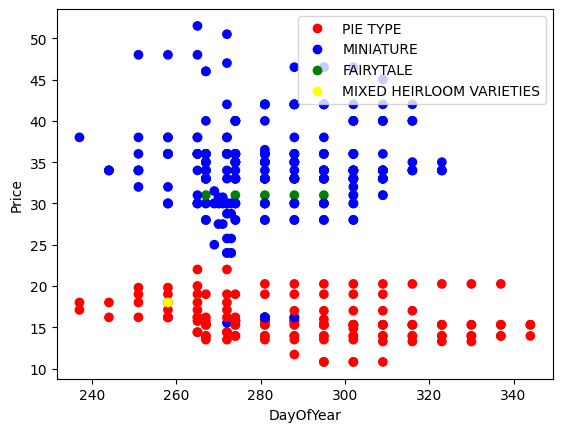

In [43]:
# Plot a scatter plot of day of year vs price and variety
p = pumpkins.with_columns(
  [pl.col("Variety").apply(lambda v: variety_colors[v]).alias("VarietyColor")])

plt.scatter(p["DayOfYear"], p["Price"], c=p["VarietyColor"])

handlelist = [
  plt.plot([], marker="o", ls="", color=color)[0]
  for color in variety_colors.values()
]
plt.xlabel("DayOfYear")
plt.ylabel("Price")
plt.legend(handlelist, variety_colors.keys(), loc="upper right", ncols=1)
plt.show()

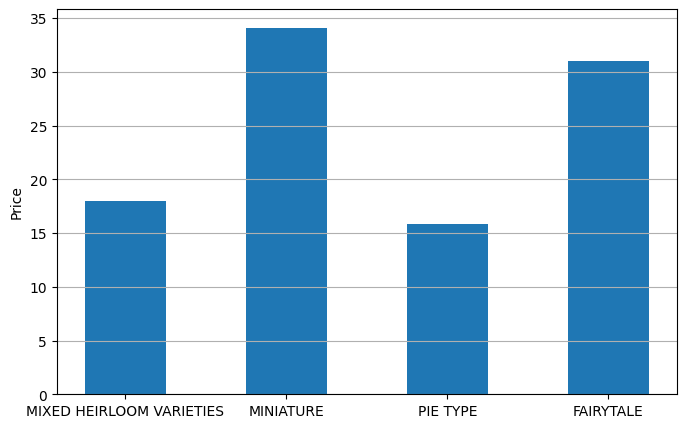

In [44]:
# Plot the mean according to the variety
p = pumpkins.groupby("Variety").agg([pl.col("Price").mean()])

plt.figure(figsize=(8, 5))
plt.bar("Variety", "Price", data=p, width=0.5)
plt.ylabel("Price")
plt.grid(axis="y")
plt.show()

In [45]:
# Correlation by variety
correlation_day_price = pumpkins.groupby([pl.col("Variety")]) \
  .agg(
    [pl.corr(pl.col("DayOfYear").cast(pl.Float64), pl.col("Price")).alias("Correlation")])

pp(correlation_day_price)

# Filter by one variety
pie_pumpkins = pumpkins.filter(pl.col("Variety") == "PIE TYPE").select(
  [
  pl.all().exclude(["Month", "DayOfYear"]),
  pl.col("Month").cast(pl.Float64),
  pl.col("DayOfYear").cast(pl.Float64),
  ])

correlation_day_price = pie_pumpkins.select([pl.corr("DayOfYear", "Price").alias("Correlation")])
print(
  f"Variety: Pie Type. Correlation DayOfYear vs Price: {correlation_day_price}"
)
pie_pumpkins.describe()


shape: (4, 2)
┌──────────────────────────┬─────────────┐
│ Variety                  ┆ Correlation │
│ ---                      ┆ ---         │
│ str                      ┆ f64         │
╞══════════════════════════╪═════════════╡
│ PIE TYPE                 ┆ -0.266786   │
│ MIXED HEIRLOOM VARIETIES ┆ NaN         │
│ MINIATURE                ┆ 0.062367    │
│ FAIRYTALE                ┆ NaN         │
└──────────────────────────┴─────────────┘
Variety: Pie Type. Correlation DayOfYear vs Price: shape: (1, 1)
┌─────────────┐
│ Correlation │
│ ---         │
│ f64         │
╞═════════════╡
│ -0.266786   │
└─────────────┘


describe,Package,Variety,City Name,Low Price,High Price,Date,Price,Month,DayOfYear
str,str,str,str,f64,f64,str,f64,f64,f64
"""count""","""144""","""144""","""144""",144.0,144.0,"""144""",144.0,144.0,144.0
"""null_count""","""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0
"""mean""",null,null,null,16.975694,17.722222,null,15.862674,10.027778,290.458333
"""std""",null,null,null,2.293446,2.341312,null,2.300743,0.884556,24.914364
"""min""","""1 1/9 bushel c…","""PIE TYPE""","""ATLANTA""",12.0,12.0,"""2016-09-24""",10.8,8.0,237.0
"""max""","""bushel cartons…","""PIE TYPE""","""SAN FRANCISCO""",22.5,24.0,"""2017-09-30""",22.0,12.0,344.0
"""median""",null,null,null,17.0,18.0,null,15.3,10.0,288.0
"""25%""",null,null,null,15.0,16.0,null,13.95,9.0,272.0
"""75%""",null,null,null,18.0,19.0,null,17.0,11.0,309.0


## Linear Regression

In [46]:
# Array of input values (features)
X = pie_pumpkins["DayOfYear"].to_numpy().reshape(-1, 1)
# Array of output values (labels)
Y = pie_pumpkins["Price"].to_numpy().reshape(-1, 1)


In [47]:
# Split the dataset into two groups for training and testing the model
#   The test data will be 20% from the overall dataset
X_train, X_test, Y_train, Y_test = train_test_split(
  X, Y, test_size=0.2, random_state=1)



In [48]:
# Create an empty Linear Regresion Model
linear_regresssion = LinearRegression()
# Fit (populate) the model
linear_regresssion.fit(X_train, Y_train)

# Correlation coeficient
print(f"Coefficients of Correlation: {linear_regresssion.coef_}")

print(f"Y-axis intercept: {linear_regresssion.intercept_}")

print(
  f"Linear Equation: y = b + mx = {linear_regresssion.intercept_[0]:.3f} + {linear_regresssion.coef_[0][0]:.3f}x"
)


Coefficients of Correlation: [[-0.02263469]]
Y-axis intercept: [22.50609239]
Linear Equation: y = b + mx = 22.506 + -0.023x


In [53]:
# Evaluate the model by trying to predict prices with the test data
predictions = linear_regresssion.predict(X_test)

mean_error = np.sqrt(mean_squared_error(Y_test, predictions))

mse = mean_squared_error(Y_test, predictions)
rss = mean_squared_error(Y_test, predictions) * len(Y_test) 

print(
  f"Mean error: {mean_error:3.3} ({mean_error/ np.mean(predictions) * 100:3.3} %)"
)

score = linear_regresssion.score(X_test, Y_test)
print(f"Model determination (score): {score}")

print(' residual sum of squares is : '+ str(np.sum(np.square(Y_test - predictions))))

print(f"MSE = {mse}")
print(f"RSS = {rss}")

Mean error: 1.74 (11.0 %)
Model determination (score): 0.1236421114492523
 residual sum of squares is : 87.5554056832284
MSE = 3.019151920111324
RSS = 87.5554056832284


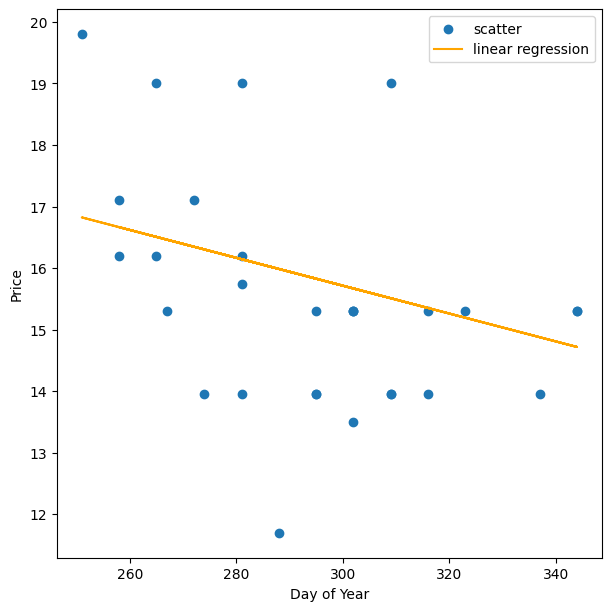

In [18]:
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

ax.scatter(X_test, Y_test, label="scatter")
ax.plot(X_test, predictions, color="orange", label="linear regression")
ax.set_xlabel("Day of Year")
ax.set_ylabel("Price")
ax.legend()

In [19]:
# Predic the pumpink price on certain day
pumpkin_price = linear_regresssion.predict([[256]])
print(f"Pumpkin price at day 256: $ {pumpkin_price[0][0]:.3f}")

Pumpkin price at day 256: $ 16.712


## Polynomial Regression

In [20]:
# poly = PolynomialFeatures(2)
# poly.fit_transform(X_train)

In [21]:
# Create a pipeline of estimators
estimators_pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

estimators_pipeline.fit(X_train, Y_train)

predictions = estimators_pipeline.predict(X_test)

mean_error = np.sqrt(mean_squared_error(Y_test, predictions))

print(
  f"Mean error: {mean_error:3.3} ({mean_error/ np.mean(predictions) * 100:3.3} %)"
)

#score = estimators_pipeline.score(X_train, Y_train)
score = estimators_pipeline.score(X_test, Y_test)
print(f"Model determination (score): {score}")


Mean error: 1.66 (10.5 %)
Model determination (score): 0.19601515846617845


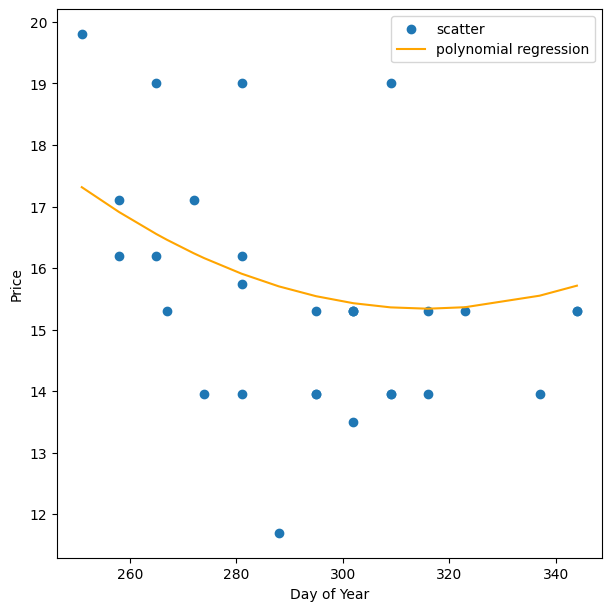

In [22]:
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

ax.scatter(X_test, Y_test, label="scatter")
ax.plot(
  sorted(X_test),
  estimators_pipeline.predict(sorted(X_test)),
  color="orange",
  label="polynomial regression")
ax.set_xlabel("Day of Year")
ax.set_ylabel("Price")
ax.legend()

## Categorical Features

In [23]:
vf = pumpkins.select(pl.col("Variety").alias("")).to_dummies(
  None, separator="")
vf.sample(10)

FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
u8,u8,u8,u8
0,0,0,1
0,0,0,1
0,1,0,0
0,1,0,0
0,1,0,0
0,0,0,1
0,1,0,0
0,1,0,0
0,1,0,0


## Linear Regression Unified

In [24]:
results_data = []

In [25]:
# DayOfYear Linear

# Array of input values (features)
X = pie_pumpkins["DayOfYear"].to_numpy().reshape(-1, 1)
# Array of output values (labels)
Y = pie_pumpkins["Price"].to_numpy().reshape(-1, 1)

result = run_linear_regression(X, Y)

results_data = format_results("DayOfYear Linear", results_data, result)


In [26]:
# DayOfYear Polynomial

# Array of input values (features)
X = pie_pumpkins["DayOfYear"].to_numpy().reshape(-1, 1)
# Array of output values (labels)
Y = pie_pumpkins["Price"].to_numpy().reshape(-1, 1)

result = run_polynomial_regression(X, Y)
results_data = format_results("DayOfYear Polynomial", results_data, result)

In [27]:
# Variety Linear

X = pumpkins.select(pl.col("Variety").alias("")).to_dummies(None, separator="")

Y = pumpkins.select(pl.col("Price"))

result = run_linear_regression(X, Y)

results_data = format_results("Variety Linear", results_data, result)

In [28]:
# All features Linear
X = pumpkins.select(pl.col("Month")).with_columns(
  pumpkins.select(pl.col("Variety").alias("")).to_dummies(None,
  separator="")).with_columns(
  pumpkins.select(pl.col("City Name").alias("")).to_dummies(
  None, separator="")).with_columns(
  pumpkins.select(pl.col("Package").alias("")).to_dummies(None, separator=""))

Y = pumpkins.select(pl.col("Price"))

result = run_linear_regression(X, Y)
results_data = format_results("All features Linear", results_data, result)

In [29]:
# All features Polynomial
X = pumpkins.select(pl.col("Month")).with_columns(
  pumpkins.select(pl.col("Variety").alias("")).to_dummies(None,
  separator="")).with_columns(
  pumpkins.select(pl.col("City Name").alias("")).to_dummies(
  None, separator="")).with_columns(
  pumpkins.select(pl.col("Package").alias("")).to_dummies(None, separator=""))

Y = pumpkins.select(pl.col("Price"))

result = run_polynomial_regression(X, Y)
results_data = format_results("All features Polynomial", results_data, result)

In [30]:
# Display results

display = PrettyTable()
display.field_names = ["Model", "MSE", "Determination"]
display.add_rows(results_data)
display.align["Model"] = "l"
print(display)

+-------------------------+----------------+---------------+
| Model                   |      MSE       | Determination |
+-------------------------+----------------+---------------+
| DayOfYear Linear        | 2.76 (17.35 %) |      0.04     |
| DayOfYear Polynomial    | 2.73 (17.16 %) |      0.07     |
| Variety Linear          | 5.34 (20.07 %) |      0.77     |
| All features Linear     | 2.92 (10.88 %) |      0.94     |
| All features Polynomial | 2.19 (8.14 %)  |      0.97     |
+-------------------------+----------------+---------------+
